In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [8]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [9]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [10]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [11]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 39, 'n_layers': 3, 'dropout': 0.0031343232927195652}


In [12]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [21]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2):
        super(SimpleNN, self).__init__()
        self.layers = []
        curr_size = input_dim
        for i in range(n_layers):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                nn.LeakyReLU(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=3
)

In [22]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        88,292
│    └─Sequential: 2-1                   [1, 39]                   --
│    │    └─Linear: 3-1                  [1, 149]                  (30,396)
│    │    └─ReLU: 3-2                    [1, 149]                  --
│    │    └─Dropout: 3-3                 [1, 149]                  --
│    │    └─Linear: 3-4                  [1, 95]                   (14,250)
│    │    └─ReLU: 3-5                    [1, 95]                   --
│    │    └─Dropout: 3-6                 [1, 95]                   --
│    │    └─Linear: 3-7                  [1, 41]                   (3,936)
│    │    └─ReLU: 3-8                    [1, 41]                   --
│    │    └─Dropout: 3-9                 [1, 41]                   --
│    │    └─Linear: 3-10                 [1, 39]                

In [23]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(cancer_autoencoder, simple_nn)
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 65.8 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
65.8 K    Trainable params
138 K     Non-trainable params
204 K     Total params
0.817     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jacobtye/mambaforge/envs/bmi_6114/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/jacobtye/mambaforge/envs/bmi_6114/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [24]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jacobtye/mambaforge/envs/bmi_6114/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    453.85968017578125     │
│         test_mse          │    453.85968017578125     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 453.85968017578125, 'test_mse': 453.85968017578125}]

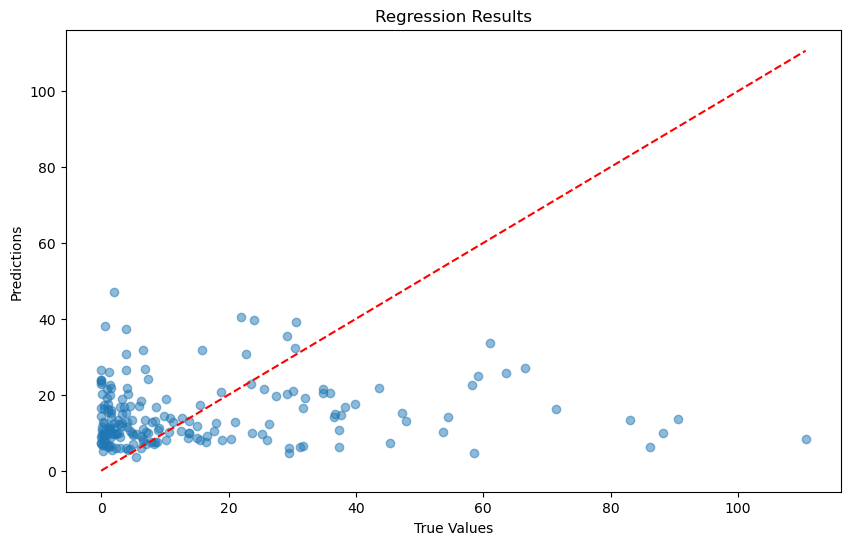

In [25]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())